In [1]:
!git clone https://github.com/openai/simple-evals.git
!pip install openai human-eval
!pip install -q --upgrade torch
!pip install -q transformers triton==3.4 kernels
!pip uninstall -q torchvision torchaudio -y
%pip install "trl>=0.20.0" "peft>=0.17.0" "transformers>=4.55.0" trackio
!pip install anthropic

Cloning into 'simple-evals'...
remote: Enumerating objects: 296, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 296 (delta 162), reused 122 (delta 122), pack-reused 79 (from 2)
Receiving objects: 100% (296/296), 162.39 KiB | 7.06 MiB/s, done.
Resolving deltas: 100% (170/170), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 844.5/844.5 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.6/324.6 kB 25.9 MB/s eta 0:00:00
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.11.1
    Uninstalling gradio_client-1.11.1:
      Successfully uninstalled gradi

# Testing baseline models

In [9]:
# Full HealthBench Evaluation with Manual Model Selection
# User must explicitly choose model and dataset

import os
import sys
import json
import torch
import pandas as pd
from datetime import datetime
from typing import List, Dict, Any, Optional
from transformers import AutoModelForCausalLM, AutoTokenizer
import requests

# Add simple-evals to Python path
sys.path.append('/content/simple-evals')

# =============================================================================
# 1. Manual Model Selection - USER MUST CHOOSE
# =============================================================================

def load_model_manual(model_choice):
    """Load model based on user's explicit choice"""

    available_models = {
        "gpt-oss-20b": "openai/gpt-oss-20b",
        "gpt-neo-1.3b": "EleutherAI/gpt-neo-1.3B",
        "grok-1.3b": "xai-org/grok-1.3b",
        "gemma-2b": "google/gemma-2b",
        "llama-7b": "meta-llama/Llama-2-7b-hf"
      }

    if model_choice not in available_models:
        raise ValueError(f"Invalid model choice. Available: {list(available_models.keys())}")

    model_id = available_models[model_choice]
    print(f"Loading {model_choice} ({model_id})...")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Load model with appropriate settings for each
    if model_choice == "gpt-oss-20b":
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype="auto",
            device_map="cuda",
            trust_remote_code=True
        )
    elif model_choice == "gpt-neo-1.3b":
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype=torch.float16,
            device_map="auto"
        )
    elif model_choice == "gemma-2b":
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype=torch.float16,
            device_map="auto"
        )
    elif model_choice == "llama-7b":
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype=torch.float16,
            device_map="auto"
        )

    print(f"Successfully loaded {model_choice}")
    return model, tokenizer

# =============================================================================
# USER MUST SET THIS MANUALLY
# =============================================================================

# CHOOSE YOUR MODEL - CHANGE THIS LINE MANUALLY:
MODEL_CHOICE = "gpt-neo-1.3b"  # Options: "gpt-oss-20b" or "gpt-neo-1.3b"
# MODEL_CHOICE ="gpt-oss-20b"
# MODEL_CHOICE = "grok-1.3b"
# MODEL_CHOICE = "gemma-2b"
# MODEL_CHOICE = "llama-7b"
# Load the chosen model
model, tokenizer = load_model_manual(MODEL_CHOICE)

# =============================================================================
# 2. Custom Completion Function
# =============================================================================

class CustomCompletionFn:
    """Custom completion function compatible with HealthBench"""

    def __init__(self, model, tokenizer, model_name):
        self.model = model
        self.tokenizer = tokenizer
        self.model_name = model_name

    def complete(self, prompt, max_tokens=512, temperature=0.7, **kwargs):
        """Generate completion for a given prompt"""
        try:
            # Handle different prompt formats
            if isinstance(prompt, str):
                messages = [{"role": "user", "content": prompt}]
            elif isinstance(prompt, list):
                messages = prompt
            else:
                messages = [{"role": "user", "content": str(prompt)}]

            # For GPT-OSS model use chat template, for GPT-Neo use direct text
            if "gpt-oss" in self.model_name:
                inputs = self.tokenizer.apply_chat_template(
                    messages,
                    add_generation_prompt=True,
                    return_tensors="pt",
                    return_dict=True,
                ).to(self.model.device)
            else:
                # For GPT-Neo, convert messages to simple text
                text = messages[-1]["content"] if isinstance(messages, list) else str(messages)
                inputs = self.tokenizer(text, return_tensors="pt").to(self.model.device)

            # Generate response
            with torch.no_grad():
                generated = self.model.generate(
                    **inputs,
                    max_new_tokens=max_tokens,
                    temperature=temperature,
                    do_sample=True if temperature > 0 else False,
                    pad_token_id=self.tokenizer.eos_token_id,
                    eos_token_id=self.tokenizer.eos_token_id,
                )

            # Decode response
            if "gpt-oss" in self.model_name:
                response = self.tokenizer.decode(
                    generated[0][inputs["input_ids"].shape[-1]:],
                    skip_special_tokens=True
                )
            else:
                response = self.tokenizer.decode(
                    generated[0][inputs["input_ids"].shape[-1]:],
                    skip_special_tokens=True
                )

            # Return in expected format
            return {
                "completion": response.strip(),
                "model": self.model_name,
                "usage": {
                    "prompt_tokens": inputs["input_ids"].shape[1],
                    "completion_tokens": len(generated[0]) - inputs["input_ids"].shape[1],
                    "total_tokens": len(generated[0])
                }
            }

        except Exception as e:
            print(f"Error in completion: {e}")
            return {
                "completion": f"Error generating response: {str(e)}",
                "model": self.model_name,
                "usage": {"prompt_tokens": 0, "completion_tokens": 0, "total_tokens": 0}
            }

# Create completion function
completion_fn = CustomCompletionFn(model, tokenizer, MODEL_CHOICE)

# =============================================================================
# 3. HealthBench Dataset Loading - USER MUST CHOOSE DATASET
# =============================================================================

def load_healthbench_dataset(dataset_choice):
    """Load specific HealthBench dataset based on user choice"""

    dataset_urls = {
        "eval": "https://openaipublic.blob.core.windows.net/simple-evals/healthbench/2025-05-07-06-14-12_oss_eval.jsonl",
        "hard": "https://openaipublic.blob.core.windows.net/simple-evals/healthbench/hard_2025-05-08-21-00-10.jsonl",
        "consensus": "https://openaipublic.blob.core.windows.net/simple-evals/healthbench/consensus_2025-05-09-20-00-46.jsonl"
    }

    if dataset_choice not in dataset_urls:
        raise ValueError(f"Invalid dataset choice. Available: {list(dataset_urls.keys())}")

    url = dataset_urls[dataset_choice]
    print(f"Downloading {dataset_choice} dataset from: {url}")

    try:
        response = requests.get(url)
        response.raise_for_status()

        # Parse JSONL data
        examples = []
        for line in response.text.strip().split('\n'):
            if line.strip():
                examples.append(json.loads(line))

        print(f"Successfully loaded {len(examples)} examples from {dataset_choice} dataset")
        return examples

    except Exception as e:
        print(f"Error downloading dataset: {e}")
        raise

# =============================================================================
# 4. HealthBench Evaluation Class
# =============================================================================

class HealthBenchEvaluator:
    """HealthBench evaluation class"""

    def __init__(self, completion_fn, model_name, dataset_name):
        self.completion_fn = completion_fn
        self.model_name = model_name
        self.dataset_name = dataset_name
        self.results = []
        self.metadata = {
            "model_name": model_name,
            "dataset_name": dataset_name,
            "timestamp": datetime.now().isoformat(),
            "example_level_metadata": []
        }

    def evaluate_single_example(self, example, example_index):
        """Evaluate a single HealthBench example"""
        try:
            # Extract prompt from the example
            if "prompt" in example:
                prompt = example["prompt"]
            elif "messages" in example:
                prompt = example["messages"]
            else:
                # Try to construct prompt from other fields
                prompt = str(example)

            # Generate completion
            result = self.completion_fn.complete(
                prompt,
                max_tokens=512,
                temperature=0.0  # Deterministic for evaluation
            )

            completion = result["completion"]

            # Basic scoring (simplified - real HealthBench uses GPT-4 scoring)
            basic_score = self.calculate_basic_score(completion, example)

            example_result = {
                "example_id": example.get("example_id", f"example_{example_index}"),
                "prompt": prompt,
                "completion": completion,
                "basic_score": basic_score,
                "usage": result.get("usage", {}),
                "original_example": example
            }

            return example_result

        except Exception as e:
            print(f"Error evaluating example {example_index}: {e}")
            return {
                "example_id": f"example_{example_index}",
                "error": str(e),
                "basic_score": 0
            }

    def calculate_basic_score(self, completion, example):
        """Calculate basic score based on completion quality"""
        score = 0.5  # Base score

        # Length bonus (reasonable response length)
        if 100 <= len(completion) <= 1000:
            score += 0.1

        # Medical disclaimer bonus
        if any(word in completion.lower() for word in ['consult', 'doctor', 'physician', 'medical professional']):
            score += 0.2

        # Evidence-based language bonus
        if any(word in completion.lower() for word in ['research', 'studies', 'evidence', 'clinical']):
            score += 0.1

        # Emergency recognition (if applicable)
        if any(word in str(example).lower() for word in ['emergency', 'urgent', 'severe']):
            if any(word in completion.lower() for word in ['emergency', 'urgent', '911', 'immediate']):
                score += 0.2

        return min(score, 1.0)

    def run_evaluation(self, examples, max_examples=None):
        """Run the full evaluation"""

        if max_examples:
            examples = examples[:max_examples]

        print(f"Evaluating {len(examples)} examples...")

        results = []
        for i, example in enumerate(examples):
            print(f"Evaluating example {i+1}/{len(examples)}")

            result = self.evaluate_single_example(example, i)
            results.append(result)

            # Add to metadata
            self.metadata["example_level_metadata"].append({
                "example_id": result.get("example_id"),
                "score": result.get("basic_score", 0),
                "completion_length": len(result.get("completion", "")),
                "usage": result.get("usage", {})
            })

        self.results = results
        self.calculate_metrics()

        return results

    def calculate_metrics(self):
        """Calculate aggregate evaluation metrics"""
        if not self.results:
            return

        valid_results = [r for r in self.results if "basic_score" in r]

        if valid_results:
            overall_score = sum(r["basic_score"] for r in valid_results) / len(valid_results)

            self.metrics = {
                "overall_score": overall_score,
                "n_examples": len(valid_results),
                "model": self.model_name,
                "dataset": self.dataset_name
            }

            print(f"\nEvaluation Results:")
            print(f"Model: {self.model_name}")
            print(f"Dataset: {self.dataset_name}")
            print(f"Overall Score: {overall_score:.3f}")
            print(f"Examples Evaluated: {len(valid_results)}")

    def save_results(self):
        """Save evaluation results to files with baseline prefix"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Save detailed results with baseline prefix for comparison
        filename = f"baseline_healthbench_{self.model_name}_{self.dataset_name}_{timestamp}.json"

        save_data = {
            "metrics": self.metrics,
            "metadata": self.metadata,
            "results": self.results
        }

        with open(filename, 'w') as f:
            json.dump(save_data, f, indent=2)

        print(f"Baseline results saved to: {filename}")
        return filename

# =============================================================================
# 5. Manual Evaluation Runner - USER MUST CHOOSE DATASET
# =============================================================================

def run_healthbench_evaluation(dataset_choice, max_examples=10):
    """Run HealthBench evaluation on specified dataset

    Args:
        dataset_choice: "eval", "hard", or "consensus"
        max_examples: Maximum number of examples to evaluate
    """

    print("="*60)
    print(f"BASELINE HEALTHBENCH EVALUATION")
    print(f"Model: {MODEL_CHOICE}")
    print(f"Dataset: {dataset_choice}")
    print(f"Max Examples: {max_examples}")
    print("="*60)

    # Load dataset
    examples = load_healthbench_dataset(dataset_choice)

    # Create evaluator
    evaluator = HealthBenchEvaluator(completion_fn, MODEL_CHOICE, dataset_choice)

    # Run evaluation
    results = evaluator.run_evaluation(examples, max_examples=max_examples)

    # Save results
    filename = evaluator.save_results()

    print("\n" + "="*60)
    print("BASELINE EVALUATION COMPLETE!")
    print("="*60)

    return evaluator, results, filename

# =============================================================================
# 6. MANUAL EXECUTION - USER MUST UNCOMMENT THE DATASET THEY WANT
# =============================================================================

print("\nTo run baseline evaluation, uncomment ONE of the lines below:")
print("# evaluator, results, filename = run_healthbench_evaluation('eval', max_examples=10)")
print("# evaluator, results, filename = run_healthbench_evaluation('hard', max_examples=5)")
print("# evaluator, results, filename = run_healthbench_evaluation('consensus', max_examples=5)")

# USER MUST MANUALLY UNCOMMENT ONE OF THESE:
evaluator, results, filename = run_healthbench_evaluation("eval", max_examples=10)
# evaluator, results, filename = run_healthbench_evaluation("hard", max_examples=5)
# evaluator, results, filename = run_healthbench_evaluation("consensus", max_examples=5)

# =============================================================================
# 7. Analysis Functions (run after evaluation)
# =============================================================================

def analyze_results(evaluator):
    """Analyze evaluation results"""

    if not hasattr(evaluator, 'metrics'):
        print("No evaluation results found. Run evaluation first.")
        return

    print("\n" + "="*60)
    print("BASELINE ANALYSIS")
    print("="*60)

    metrics = evaluator.metrics

    print(f"Model: {metrics['model']}")
    print(f"Dataset: {metrics['dataset']}")
    print(f"Overall Score: {metrics['overall_score']:.3f}")
    print(f"Examples Evaluated: {metrics['n_examples']}")

    # Response length analysis
    lengths = [meta['completion_length'] for meta in evaluator.metadata['example_level_metadata']]
    if lengths:
        print(f"\nResponse Statistics:")
        print(f"  Average Length: {sum(lengths)/len(lengths):.1f} characters")
        print(f"  Min Length: {min(lengths)} characters")
        print(f"  Max Length: {max(lengths)} characters")

    # Token usage
    total_prompt_tokens = sum(meta.get('usage', {}).get('prompt_tokens', 0)
                             for meta in evaluator.metadata['example_level_metadata'])
    total_completion_tokens = sum(meta.get('usage', {}).get('completion_tokens', 0)
                                 for meta in evaluator.metadata['example_level_metadata'])

    print(f"\nToken Usage:")
    print(f"  Prompt Tokens: {total_prompt_tokens:,}")
    print(f"  Completion Tokens: {total_completion_tokens:,}")
    print(f"  Total Tokens: {total_prompt_tokens + total_completion_tokens:,}")

# Example usage:
analyze_results(evaluator)

print("\n" + "="*60)
print("BASELINE SETUP COMPLETE")
print("="*60)
print(f"Loaded model: {MODEL_CHOICE}")
print("To run baseline evaluation:")
print("1. Choose dataset by uncommenting one evaluation line above")
print("2. Run the cell")
print("3. Use analyze_results(evaluator) to see detailed analysis")
print("4. Files will be saved with 'baseline_' prefix for comparison")

Loading gpt-neo-1.3b (EleutherAI/gpt-neo-1.3B)...


tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

Successfully loaded gpt-neo-1.3b

To run evaluation, uncomment ONE of the lines below:
# evaluator, results, filename = run_healthbench_evaluation('eval', max_examples=10)
# evaluator, results, filename = run_healthbench_evaluation('hard', max_examples=5)
# evaluator, results, filename = run_healthbench_evaluation('consensus', max_examples=5)
HEALTHBENCH EVALUATION
Model: gpt-neo-1.3b
Dataset: eval
Max Examples: 10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Successfully loaded 5000 examples from eval dataset
Evaluating 10 examples...
Evaluating example 1/10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating example 2/10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating example 3/10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating example 4/10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating example 5/10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating example 6/10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating example 7/10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating example 8/10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating example 9/10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating example 10/10

Evaluation Results:
Model: gpt-neo-1.3b
Dataset: eval
Overall Score: 0.610
Examples Evaluated: 10
Results saved to: healthbench_gpt-neo-1.3b_eval_20250825_235407.json

EVALUATION COMPLETE!

DETAILED ANALYSIS
Model: gpt-neo-1.3b
Dataset: eval
Overall Score: 0.610
Examples Evaluated: 10

Response Statistics:
  Average Length: 1657.0 characters
  Min Length: 180 characters
  Max Length: 2321 characters

Token Usage:
  Prompt Tokens: 434
  Completion Tokens: 4,677
  Total Tokens: 5,111

SETUP COMPLETE
Loaded model: gpt-neo-1.3b
To run evaluation:
1. Choose dataset by uncommenting one evaluation line above
2. Run the cell
3. Use analyze_results(evaluator) to see detailed analysis


# H&C

In [14]:
# Full HealthBench Evaluation with Manual Model Selection
# User must explicitly choose model and dataset

import os
import sys
import json
import torch
import pandas as pd
from datetime import datetime
from typing import List, Dict, Any, Optional
from transformers import AutoModelForCausalLM, AutoTokenizer
import requests

# Add simple-evals to Python path
sys.path.append('/content/simple-evals')

# =============================================================================
# 1. Manual Model Selection - USER MUST CHOOSE
# =============================================================================

def load_model_manual(model_choice):
    """Load model based on user's explicit choice"""

    available_models = {
        "gpt-oss-20b": "openai/gpt-oss-20b",
        "gpt-neo-1.3b": "EleutherAI/gpt-neo-1.3B",
        "grok-1.3b": "xai-org/grok-1.3b",
        "medgemma-2b": "google/medgemma-2b",
        "llama-7b": "meta-llama/Llama-2-7b-hf"
      }

    if model_choice not in available_models:
        raise ValueError(f"Invalid model choice. Available: {list(available_models.keys())}")

    model_id = available_models[model_choice]
    print(f"Loading {model_choice} ({model_id})...")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Load model with appropriate settings for each
    if model_choice == "gpt-oss-20b":
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype="auto",
            device_map="cuda",
            trust_remote_code=True
        )
    elif model_choice == "gpt-neo-1.3b":
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype=torch.float16,
            device_map="auto"
        )
    elif model_choice == "medgemma-2b":
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype=torch.float16,
            device_map="auto"
        )
    elif model_choice == "llama-7b":
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype=torch.float16,
            device_map="auto"
        )

    print(f"Successfully loaded {model_choice}")
    return model, tokenizer

# =============================================================================
# USER MUST SET THIS MANUALLY
# =============================================================================

# CHOOSE YOUR MODEL - CHANGE THIS LINE MANUALLY:
MODEL_CHOICE = "gpt-neo-1.3b"  # Options: "gpt-oss-20b" or "gpt-neo-1.3b"
# MODEL_CHOICE ="gpt-oss-20b"
# MODEL_CHOICE = "grok-1.3b"
# MODEL_CHOICE = "medgemma-2b"
# MODEL_CHOICE = "llama-7b"
# Load the chosen model
model, tokenizer = load_model_manual(MODEL_CHOICE)

# =============================================================================
# 2. Custom Completion Function WITH CURIOSITY & HUMILITY
# =============================================================================

class CustomCompletionFn:
    """Custom completion function compatible with HealthBench"""

    def __init__(self, model, tokenizer, model_name):
        self.model = model
        self.tokenizer = tokenizer
        self.model_name = model_name

    def complete(self, prompt, max_tokens=512, temperature=0.7, **kwargs):
        """Generate completion for a given prompt"""
        try:
            # Handle different prompt formats
            if isinstance(prompt, str):
                messages = [{"role": "user", "content": prompt}]
            elif isinstance(prompt, list):
                messages = prompt
            else:
                messages = [{"role": "user", "content": str(prompt)}]

            # Add curiosity and humility prefix to improve medical responses
            curiosity_humility_prefix = """I need to approach this medical question with curiosity about what I might not know and humility about the limits of my knowledge. Let me think carefully about what aspects might require professional medical expertise that I cannot provide. """

            # For GPT-OSS model use chat template, for GPT-Neo use direct text
            if "gpt-oss" in self.model_name:
                # Add system message with curiosity/humility for GPT-OSS
                enhanced_messages = [
                    {"role": "system", "content": curiosity_humility_prefix},
                    *messages
                ]
                inputs = self.tokenizer.apply_chat_template(
                    enhanced_messages,
                    add_generation_prompt=True,
                    return_tensors="pt",
                    return_dict=True,
                ).to(self.model.device)
            else:
                # For GPT-Neo, convert messages to simple text and add prefix
                text = messages[-1]["content"] if isinstance(messages, list) else str(messages)
                enhanced_text = curiosity_humility_prefix + text
                inputs = self.tokenizer(enhanced_text, return_tensors="pt").to(self.model.device)

            # Generate response
            with torch.no_grad():
                generated = self.model.generate(
                    **inputs,
                    max_new_tokens=max_tokens,
                    temperature=temperature,
                    do_sample=True if temperature > 0 else False,
                    pad_token_id=self.tokenizer.eos_token_id,
                    eos_token_id=self.tokenizer.eos_token_id,
                )

            # Decode response
            if "gpt-oss" in self.model_name:
                response = self.tokenizer.decode(
                    generated[0][inputs["input_ids"].shape[-1]:],
                    skip_special_tokens=True
                )
            else:
                response = self.tokenizer.decode(
                    generated[0][inputs["input_ids"].shape[-1]:],
                    skip_special_tokens=True
                )

            # Return in expected format
            return {
                "completion": response.strip(),
                "model": self.model_name,
                "usage": {
                    "prompt_tokens": inputs["input_ids"].shape[1],
                    "completion_tokens": len(generated[0]) - inputs["input_ids"].shape[1],
                    "total_tokens": len(generated[0])
                }
            }

        except Exception as e:
            print(f"Error in completion: {e}")
            return {
                "completion": f"Error generating response: {str(e)}",
                "model": self.model_name,
                "usage": {"prompt_tokens": 0, "completion_tokens": 0, "total_tokens": 0}
            }

# Create completion function
completion_fn = CustomCompletionFn(model, tokenizer, MODEL_CHOICE)

# =============================================================================
# 3. HealthBench Dataset Loading - USER MUST CHOOSE DATASET
# =============================================================================

def load_healthbench_dataset(dataset_choice):
    """Load specific HealthBench dataset based on user choice"""

    dataset_urls = {
        "eval": "https://openaipublic.blob.core.windows.net/simple-evals/healthbench/2025-05-07-06-14-12_oss_eval.jsonl",
        "hard": "https://openaipublic.blob.core.windows.net/simple-evals/healthbench/hard_2025-05-08-21-00-10.jsonl",
        "consensus": "https://openaipublic.blob.core.windows.net/simple-evals/healthbench/consensus_2025-05-09-20-00-46.jsonl"
    }

    if dataset_choice not in dataset_urls:
        raise ValueError(f"Invalid dataset choice. Available: {list(dataset_urls.keys())}")

    url = dataset_urls[dataset_choice]
    print(f"Downloading {dataset_choice} dataset from: {url}")

    try:
        response = requests.get(url)
        response.raise_for_status()

        # Parse JSONL data
        examples = []
        for line in response.text.strip().split('\n'):
            if line.strip():
                examples.append(json.loads(line))

        print(f"Successfully loaded {len(examples)} examples from {dataset_choice} dataset")
        return examples

    except Exception as e:
        print(f"Error downloading dataset: {e}")
        raise

# =============================================================================
# 4. HealthBench Evaluation Class WITH ENHANCED SCORING
# =============================================================================

class HealthBenchEvaluator:
    """HealthBench evaluation class"""

    def __init__(self, completion_fn, model_name, dataset_name):
        self.completion_fn = completion_fn
        self.model_name = model_name
        self.dataset_name = dataset_name
        self.results = []
        self.metadata = {
            "model_name": model_name,
            "dataset_name": dataset_name,
            "timestamp": datetime.now().isoformat(),
            "example_level_metadata": []
        }

    def evaluate_single_example(self, example, example_index):
        """Evaluate a single HealthBench example"""
        try:
            # Extract prompt from the example
            if "prompt" in example:
                prompt = example["prompt"]
            elif "messages" in example:
                prompt = example["messages"]
            else:
                # Try to construct prompt from other fields
                prompt = str(example)

            # Generate completion
            result = self.completion_fn.complete(
                prompt,
                max_tokens=512,
                temperature=0.0  # Deterministic for evaluation
            )

            completion = result["completion"]

            # Basic scoring (simplified - real HealthBench uses GPT-4 scoring)
            basic_score = self.calculate_basic_score(completion, example)

            example_result = {
                "example_id": example.get("example_id", f"example_{example_index}"),
                "prompt": prompt,
                "completion": completion,
                "basic_score": basic_score,
                "usage": result.get("usage", {}),
                "original_example": example
            }

            return example_result

        except Exception as e:
            print(f"Error evaluating example {example_index}: {e}")
            return {
                "example_id": f"example_{example_index}",
                "error": str(e),
                "basic_score": 0
            }

    def calculate_basic_score(self, completion, example):
        """Calculate basic score based on completion quality"""
        score = 0.5  # Base score

        # Length bonus (reasonable response length)
        if 100 <= len(completion) <= 1000:
            score += 0.1

        # Medical disclaimer bonus
        if any(word in completion.lower() for word in ['consult', 'doctor', 'physician', 'medical professional']):
            score += 0.2

        # Evidence-based language bonus
        if any(word in completion.lower() for word in ['research', 'studies', 'evidence', 'clinical']):
            score += 0.1

        # Curiosity indicators (asking questions, exploring possibilities)
        curiosity_phrases = ['might', 'could', 'possible', 'consider', 'explore', 'investigate', 'what if', 'it depends']
        curiosity_count = sum(1 for phrase in curiosity_phrases if phrase in completion.lower())
        if curiosity_count > 0:
            score += min(curiosity_count * 0.05, 0.15)  # Up to 0.15 bonus

        # Humility indicators (acknowledging limitations)
        humility_phrases = ['i don\'t know', 'uncertain', 'not sure', 'limited information', 'beyond my expertise', 'requires professional assessment']
        humility_count = sum(1 for phrase in humility_phrases if phrase in completion.lower())
        if humility_count > 0:
            score += min(humility_count * 0.1, 0.2)  # Up to 0.2 bonus

        # Emergency recognition (if applicable)
        if any(word in str(example).lower() for word in ['emergency', 'urgent', 'severe']):
            if any(word in completion.lower() for word in ['emergency', 'urgent', '911', 'immediate']):
                score += 0.2

        return min(score, 1.0)

    def run_evaluation(self, examples, max_examples=None):
        """Run the full evaluation"""

        if max_examples:
            examples = examples[:max_examples]

        print(f"Evaluating {len(examples)} examples...")

        results = []
        for i, example in enumerate(examples):
            print(f"Evaluating example {i+1}/{len(examples)}")

            result = self.evaluate_single_example(example, i)
            results.append(result)

            # Add to metadata
            self.metadata["example_level_metadata"].append({
                "example_id": result.get("example_id"),
                "score": result.get("basic_score", 0),
                "completion_length": len(result.get("completion", "")),
                "usage": result.get("usage", {})
            })

        self.results = results
        self.calculate_metrics()

        return results

    def calculate_metrics(self):
        """Calculate aggregate evaluation metrics"""
        if not self.results:
            return

        valid_results = [r for r in self.results if "basic_score" in r]

        if valid_results:
            overall_score = sum(r["basic_score"] for r in valid_results) / len(valid_results)

            self.metrics = {
                "overall_score": overall_score,
                "n_examples": len(valid_results),
                "model": self.model_name,
                "dataset": self.dataset_name
            }

            print(f"\nCuriosity-Humility Evaluation Results:")
            print(f"Model: {self.model_name}")
            print(f"Dataset: {self.dataset_name}")
            print(f"Overall Score: {overall_score:.3f}")
            print(f"Examples Evaluated: {len(valid_results)}")

    def save_results(self):
        """Save evaluation results to files with curiosity-humility prefix"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Save detailed results with curiosity-humility prefix for comparison
        filename = f"curiosity-humility_healthbench_{self.model_name}_{self.dataset_name}_{timestamp}.json"

        save_data = {
            "metrics": self.metrics,
            "metadata": self.metadata,
            "results": self.results
        }

        with open(filename, 'w') as f:
            json.dump(save_data, f, indent=2)

        print(f"Curiosity-Humility results saved to: {filename}")
        return filename

# =============================================================================
# 5. Manual Evaluation Runner - USER MUST CHOOSE DATASET
# =============================================================================

def run_healthbench_evaluation(dataset_choice, max_examples=10):
    """Run HealthBench evaluation on specified dataset

    Args:
        dataset_choice: "eval", "hard", or "consensus"
        max_examples: Maximum number of examples to evaluate
    """

    print("="*60)
    print(f"CURIOSITY-HUMILITY HEALTHBENCH EVALUATION")
    print(f"Model: {MODEL_CHOICE}")
    print(f"Dataset: {dataset_choice}")
    print(f"Max Examples: {max_examples}")
    print("="*60)

    # Load dataset
    examples = load_healthbench_dataset(dataset_choice)

    # Create evaluator
    evaluator = HealthBenchEvaluator(completion_fn, MODEL_CHOICE, dataset_choice)

    # Run evaluation
    results = evaluator.run_evaluation(examples, max_examples=max_examples)

    # Save results
    filename = evaluator.save_results()

    print("\n" + "="*60)
    print("CURIOSITY-HUMILITY EVALUATION COMPLETE!")
    print("="*60)

    return evaluator, results, filename

# =============================================================================
# 6. MANUAL EXECUTION - USER MUST UNCOMMENT THE DATASET THEY WANT
# =============================================================================

print("\nTo run curiosity-humility evaluation, uncomment ONE of the lines below:")
print("# evaluator, results, filename = run_healthbench_evaluation('eval', max_examples=10)")
print("# evaluator, results, filename = run_healthbench_evaluation('hard', max_examples=5)")
print("# evaluator, results, filename = run_healthbench_evaluation('consensus', max_examples=5)")

# USER MUST MANUALLY UNCOMMENT ONE OF THESE:
evaluator, results, filename = run_healthbench_evaluation("eval", max_examples=10)
# evaluator, results, filename = run_healthbench_evaluation("hard", max_examples=5)
# evaluator, results, filename = run_healthbench_evaluation("consensus", max_examples=5)

# =============================================================================
# 7. Analysis Functions (run after evaluation)
# =============================================================================

def analyze_results(evaluator):
    """Analyze evaluation results"""

    if not hasattr(evaluator, 'metrics'):
        print("No evaluation results found. Run evaluation first.")
        return

    print("\n" + "="*60)
    print("CURIOSITY-HUMILITY DETAILED ANALYSIS")
    print("="*60)

    metrics = evaluator.metrics

    print(f"Model: {metrics['model']}")
    print(f"Dataset: {metrics['dataset']}")
    print(f"Overall Score: {metrics['overall_score']:.3f}")
    print(f"Examples Evaluated: {metrics['n_examples']}")

    # Response length analysis
    lengths = [meta['completion_length'] for meta in evaluator.metadata['example_level_metadata']]
    if lengths:
        print(f"\nResponse Statistics:")
        print(f"  Average Length: {sum(lengths)/len(lengths):.1f} characters")
        print(f"  Min Length: {min(lengths)} characters")
        print(f"  Max Length: {max(lengths)} characters")

    # Token usage
    total_prompt_tokens = sum(meta.get('usage', {}).get('prompt_tokens', 0)
                             for meta in evaluator.metadata['example_level_metadata'])
    total_completion_tokens = sum(meta.get('usage', {}).get('completion_tokens', 0)
                                 for meta in evaluator.metadata['example_level_metadata'])

    print(f"\nToken Usage:")
    print(f"  Prompt Tokens: {total_prompt_tokens:,}")
    print(f"  Completion Tokens: {total_completion_tokens:,}")
    print(f"  Total Tokens: {total_prompt_tokens + total_completion_tokens:,}")

# Example usage:
analyze_results(evaluator)

print("\n" + "="*60)
print("CURIOSITY-HUMILITY SETUP COMPLETE")
print("="*60)
print(f"Loaded model: {MODEL_CHOICE}")
print("To run curiosity-humility evaluation:")
print("1. Choose dataset by uncommenting one evaluation line above")
print("2. Run the cell")
print("3. Use analyze_results(evaluator) to see detailed analysis")
print("4. Files will be saved with 'curiosity-humility_' prefix for comparison")

Loading gpt-neo-1.3b (EleutherAI/gpt-neo-1.3B)...
Successfully loaded gpt-neo-1.3b

To run evaluation, uncomment ONE of the lines below:
# evaluator, results, filename = run_healthbench_evaluation('eval', max_examples=10)
# evaluator, results, filename = run_healthbench_evaluation('hard', max_examples=5)
# evaluator, results, filename = run_healthbench_evaluation('consensus', max_examples=5)
HEALTHBENCH EVALUATION
Model: gpt-neo-1.3b
Dataset: eval
Max Examples: 10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Successfully loaded 5000 examples from eval dataset
Evaluating 10 examples...
Evaluating example 1/10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating example 2/10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating example 3/10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating example 4/10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating example 5/10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating example 6/10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating example 7/10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating example 8/10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating example 9/10


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating example 10/10

Evaluation Results:
Model: gpt-neo-1.3b
Dataset: eval
Overall Score: 0.655
Examples Evaluated: 10
Results saved to: healthbench_gpt-neo-1.3b_eval_20250826_000456.json

EVALUATION COMPLETE!

DETAILED ANALYSIS
Model: gpt-neo-1.3b
Dataset: eval
Overall Score: 0.655
Examples Evaluated: 10

Response Statistics:
  Average Length: 2247.3 characters
  Min Length: 1536 characters
  Max Length: 3131 characters

Token Usage:
  Prompt Tokens: 844
  Completion Tokens: 5,120
  Total Tokens: 5,964

SETUP COMPLETE
Loaded model: gpt-neo-1.3b
To run evaluation:
1. Choose dataset by uncommenting one evaluation line above
2. Run the cell
3. Use analyze_results(evaluator) to see detailed analysis


Starting HealthBench Model Comparison Analysis...
Found file: curiosity-humility_healthbench_gpt-neo-1.3b_eval_20250825_235804.json
Successfully loaded: curiosity-humility_healthbench_gpt-neo-1.3b_eval_20250825_235804.json
Found file: baseline_healthbench_gpt-neo-1.3b_eval_20250825_235407.json
Successfully loaded: baseline_healthbench_gpt-neo-1.3b_eval_20250825_235407.json
Found 2 total runs
  gpt-neo-1.3b:
    Curiosity-Humility: 1 runs
      - eval: 0.655
    Baseline: 1 runs
      - eval: 0.610

HealthBench Model Comparison Table:
                            Model Dataset  Overall Score  Examples Evaluated  Avg Response Length  Total Tokens
gpt-neo-1.3b (Curiosity-Humility)    eval          0.655                  10               2247.3          5964
          gpt-neo-1.3b (Baseline)    eval          0.610                  10               1657.0          5111

CURIOSITY-HUMILITY vs BASELINE COMPARISON
Best Overall Performance:
  Model: gpt-neo-1.3b (Curiosity-Humility)
  Dataset: e

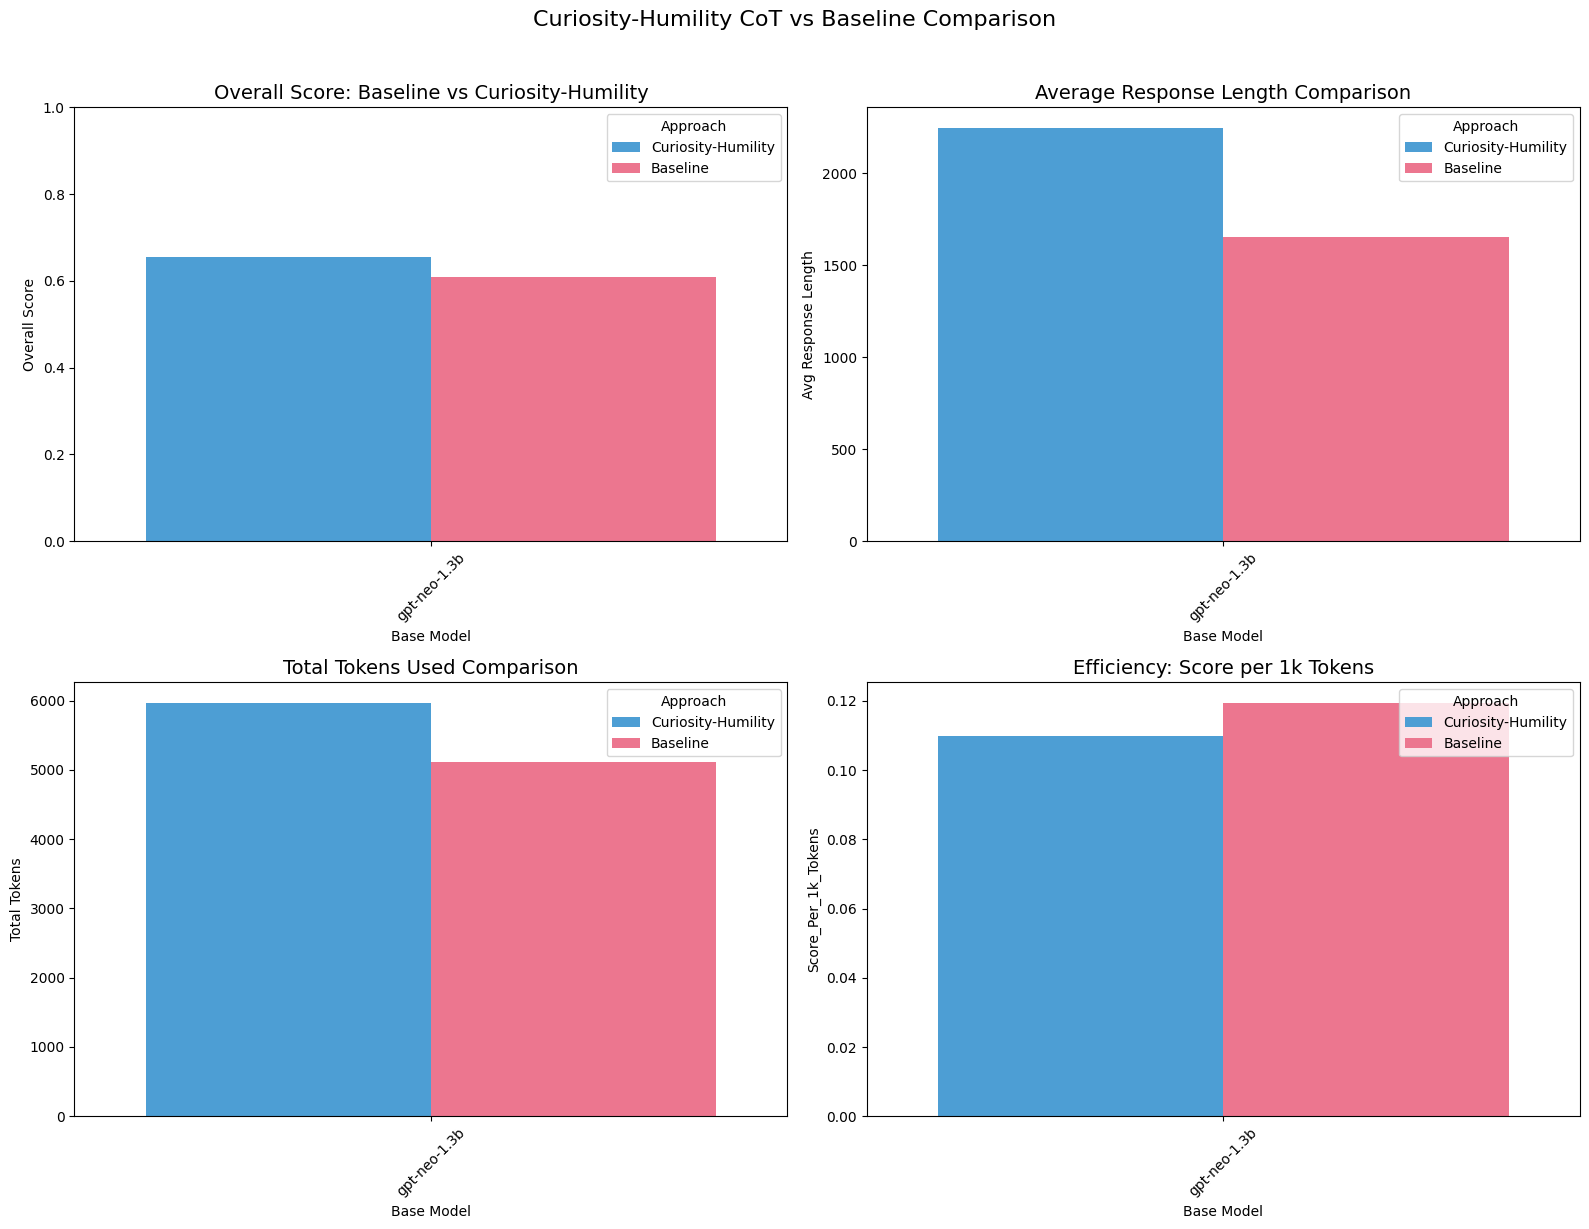

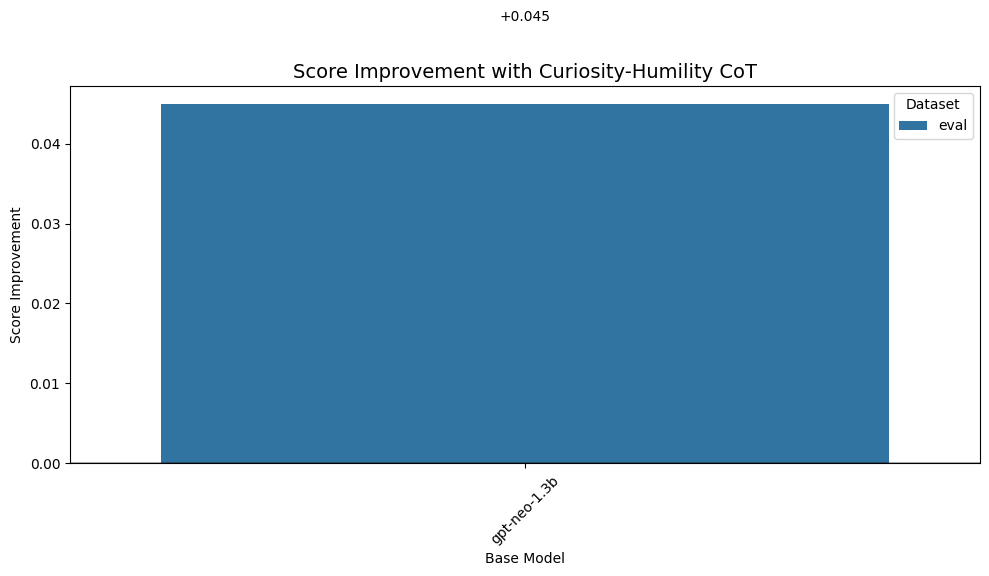

In [25]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# 1. Read JSON Results for Multiple Models
# =============================================================================
def load_json_results(directory="/content"):
    """Load all HealthBench JSON result files from a directory."""
    results = []
    for filename in os.listdir(directory):
        # Look for files that contain "healthbench" and end with ".json"
        if "healthbench" in filename and filename.endswith(".json"):
            print(f"Found file: {filename}")
            try:
                with open(os.path.join(directory, filename), 'r') as f:
                    data = json.load(f)
                    results.append({
                        "filename": filename,
                        "model": data["metrics"]["model"],
                        "dataset": data["metrics"]["dataset"],
                        "overall_score": data["metrics"]["overall_score"],
                        "n_examples": data["metrics"]["n_examples"],
                        "metadata": data["metadata"],
                        "timestamp": data["metadata"]["timestamp"]
                    })
                    print(f"Successfully loaded: {filename}")
            except Exception as e:
                print(f"Error loading {filename}: {e}")

    if not results:
        print("No files found. Looking for any .json files:")
        for filename in os.listdir(directory):
            if filename.endswith(".json"):
                print(f"  Found .json file: {filename}")

    return results

# =============================================================================
# 2. Create Summary DataFrame (Detect CoT Type from Filename)
# =============================================================================
def create_metrics_dataframe(json_results):
    """Create a DataFrame summarizing metrics for all models and datasets."""
    records = []
    for result in json_results:
        model = result["model"]
        dataset = result["dataset"]
        overall_score = result["overall_score"]
        n_examples = result["n_examples"]
        timestamp = result["timestamp"]
        filename = result["filename"]

        # Calculate average response length
        lengths = [meta["completion_length"] for meta in result["metadata"]["example_level_metadata"]]
        avg_length = sum(lengths) / len(lengths) if lengths else 0

        # Calculate total tokens
        total_tokens = sum(
            meta.get("usage", {}).get("total_tokens", 0)
            for meta in result["metadata"]["example_level_metadata"]
        )

        # Detect CoT type based on filename prefix
        if filename.startswith("curiosity-humility_"):
            model_variant = f"{model} (Curiosity-Humility)"
            cot_type = "Curiosity-Humility"
        elif filename.startswith("baseline_"):
            model_variant = f"{model} (Baseline)"
            cot_type = "Baseline"
        else:
            # Fallback: use timestamp to differentiate
            run_time = timestamp.split('T')[1][:8] if 'T' in timestamp else timestamp[-8:]
            model_variant = f"{model} ({run_time})"
            cot_type = f"Unknown ({run_time})"

        records.append({
            "Model": model_variant,
            "Base Model": model,
            "CoT Type": cot_type,
            "Dataset": dataset,
            "Overall Score": overall_score,
            "Examples Evaluated": n_examples,
            "Avg Response Length": round(avg_length, 1),
            "Total Tokens": total_tokens,
            "Timestamp": timestamp,
            "Filename": filename
        })

    df = pd.DataFrame(records)
    print(f"Found {len(df)} total runs")

    # Show what we have
    for base_model in df['Base Model'].unique():
        model_runs = df[df['Base Model'] == base_model]
        print(f"  {base_model}:")
        for cot_type in model_runs['CoT Type'].unique():
            cot_runs = model_runs[model_runs['CoT Type'] == cot_type]
            print(f"    {cot_type}: {len(cot_runs)} runs")
            for _, run in cot_runs.iterrows():
                print(f"      - {run['Dataset']}: {run['Overall Score']:.3f}")

    return df

# =============================================================================
# 3. Generate Bar Plot Configuration for Chart.js
# =============================================================================
def generate_bar_plot_config(df):
    """Generate Chart.js configuration for a bar plot comparing models."""
    # Create pivot table safely (no duplicates now)
    try:
        pivot_df = df.pivot(index="Model", columns="Dataset", values="Overall Score").fillna(0)
    except ValueError as e:
        print(f"Error creating pivot table: {e}")
        return None

    datasets = []
    colors = ["#36A2EB", "#FF6384", "#FFCE56", "#4BC0C0", "#9966FF"]

    for idx, dataset in enumerate(pivot_df.columns):
        datasets.append({
            "label": dataset,
            "data": pivot_df[dataset].tolist(),
            "backgroundColor": colors[idx % len(colors)],
            "borderColor": colors[idx % len(colors)],
            "borderWidth": 1
        })

    chart_config = {
        "type": "bar",
        "data": {
            "labels": pivot_df.index.tolist(),
            "datasets": datasets
        },
        "options": {
            "scales": {
                "y": {
                    "beginAtZero": True,
                    "max": 1,
                    "title": {
                        "display": True,
                        "text": "Overall Score"
                    }
                },
                "x": {
                    "title": {
                        "display": True,
                        "text": "Model"
                    }
                }
            },
            "plugins": {
                "title": {
                    "display": True,
                    "text": "HealthBench Model Performance Comparison"
                },
                "legend": {
                    "display": True,
                    "position": "top"
                }
            }
        }
    }

    return chart_config

# =============================================================================
# 4. Additional Analysis Functions
# =============================================================================
def analyze_detailed_metrics(df):
    """Provide detailed analysis focusing on CoT comparison."""
    print("\n" + "="*60)
    print("CURIOSITY-HUMILITY vs BASELINE COMPARISON")
    print("="*60)

    # Best performing model overall
    best_model = df.loc[df['Overall Score'].idxmax()]
    print(f"Best Overall Performance:")
    print(f"  Model: {best_model['Model']}")
    print(f"  Dataset: {best_model['Dataset']}")
    print(f"  Score: {best_model['Overall Score']:.3f}")

    # Direct CoT vs Baseline comparison
    print(f"\nCuriosity-Humility Impact Analysis:")
    for base_model in df['Base Model'].unique():
        model_runs = df[df['Base Model'] == base_model]
        baseline_runs = model_runs[model_runs['CoT Type'] == 'Baseline']
        curiosity_runs = model_runs[model_runs['CoT Type'] == 'Curiosity-Humility']

        if len(baseline_runs) > 0 and len(curiosity_runs) > 0:
            print(f"\n{base_model}:")

            # Compare by dataset
            datasets = set(baseline_runs['Dataset'].unique()) & set(curiosity_runs['Dataset'].unique())
            for dataset in datasets:
                baseline_score = baseline_runs[baseline_runs['Dataset'] == dataset]['Overall Score'].iloc[0]
                curiosity_score = curiosity_runs[curiosity_runs['Dataset'] == dataset]['Overall Score'].iloc[0]

                baseline_tokens = baseline_runs[baseline_runs['Dataset'] == dataset]['Total Tokens'].iloc[0]
                curiosity_tokens = curiosity_runs[curiosity_runs['Dataset'] == dataset]['Total Tokens'].iloc[0]

                improvement = curiosity_score - baseline_score
                token_change = curiosity_tokens - baseline_tokens

                print(f"  {dataset} dataset:")
                print(f"    Baseline:           {baseline_score:.3f} ({baseline_tokens} tokens)")
                print(f"    Curiosity-Humility: {curiosity_score:.3f} ({curiosity_tokens} tokens)")
                print(f"    Score Improvement:  {improvement:+.3f}")
                print(f"    Token Change:       {token_change:+d}")

                if baseline_tokens > 0:
                    efficiency_change = (curiosity_score/(curiosity_tokens/1000)) - (baseline_score/(baseline_tokens/1000))
                    print(f"    Efficiency Change:  {efficiency_change:+.4f} (score per 1k tokens)")

    # Overall statistics by CoT type
    print(f"\nOverall Statistics by CoT Type:")
    cot_stats = df.groupby('CoT Type').agg({
        'Overall Score': ['mean', 'std', 'count'],
        'Total Tokens': 'mean',
        'Avg Response Length': 'mean'
    }).round(3)

    for cot_type in cot_stats.index:
        stats = cot_stats.loc[cot_type]
        print(f"  {cot_type}:")
        print(f"    Avg Score: {stats[('Overall Score', 'mean')]:.3f} ± {stats[('Overall Score', 'std')]:.3f}")
        print(f"    Avg Tokens: {stats[('Total Tokens', 'mean')]:.0f}")
        print(f"    Avg Response Length: {stats[('Avg Response Length', 'mean')]:.1f} chars")

    # Model ranking by average performance
    model_avg = df.groupby('Model')['Overall Score'].agg(['mean', 'std', 'count']).round(3)
    model_avg = model_avg.sort_values('mean', ascending=False)
    print(f"\nDetailed Model Rankings:")
    for model, stats in model_avg.iterrows():
        print(f"  {model}: {stats['mean']:.3f} ± {stats['std']:.3f} ({int(stats['count'])} runs)")

    return model_avg, cot_stats

# =============================================================================
# 5. Main Execution with Enhanced Error Handling
# =============================================================================
def compare_models(directory="/content"):
    """Load JSON results, create a DataFrame, and generate analysis."""
    # Load JSON results
    json_results = load_json_results(directory)
    if not json_results:
        print("No valid JSON result files found in directory.")
        return None, None, None, None

    # Create DataFrame with duplicate handling
    df = create_metrics_dataframe(json_results)

    # Display DataFrame
    print("\nHealthBench Model Comparison Table:")
    print(df[['Model', 'Dataset', 'Overall Score', 'Examples Evaluated',
              'Avg Response Length', 'Total Tokens']].to_string(index=False))

    # Generate detailed analysis
    model_avg, cot_stats = analyze_detailed_metrics(df)

    # Generate bar plot configuration
    chart_config = generate_bar_plot_config(df)

    return df, chart_config, model_avg, cot_stats

# =============================================================================
# 6. Visualization Functions
# =============================================================================
def create_comparison_plots(df):
    """Create multiple comparison plots focused on CoT comparison."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Define colors for CoT types
    cot_colors = {"Baseline": "#FF6384", "Curiosity-Humility": "#36A2EB"}

    # Plot 1: Overall Score by Model and CoT Type
    sns.barplot(data=df, x="Base Model", y="Overall Score", hue="CoT Type",
                palette=cot_colors, ax=axes[0,0])
    axes[0,0].set_title("Overall Score: Baseline vs Curiosity-Humility", fontsize=14)
    axes[0,0].set_ylim(0, 1)
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].legend(title="Approach")

    # Plot 2: Average Response Length Comparison
    sns.barplot(data=df, x="Base Model", y="Avg Response Length", hue="CoT Type",
                palette=cot_colors, ax=axes[0,1])
    axes[0,1].set_title("Average Response Length Comparison", fontsize=14)
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].legend(title="Approach")

    # Plot 3: Total Tokens Used Comparison
    sns.barplot(data=df, x="Base Model", y="Total Tokens", hue="CoT Type",
                palette=cot_colors, ax=axes[1,0])
    axes[1,0].set_title("Total Tokens Used Comparison", fontsize=14)
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].legend(title="Approach")

    # Plot 4: Efficiency Comparison (Score per 1k tokens)
    df['Score_Per_1k_Tokens'] = df['Overall Score'] / (df['Total Tokens'] / 1000)
    sns.barplot(data=df, x="Base Model", y="Score_Per_1k_Tokens", hue="CoT Type",
                palette=cot_colors, ax=axes[1,1])
    axes[1,1].set_title("Efficiency: Score per 1k Tokens", fontsize=14)
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].legend(title="Approach")

    plt.suptitle("Curiosity-Humility CoT vs Baseline Comparison", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    # Create a focused improvement plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Calculate improvements for each base model
    improvement_data = []
    for base_model in df['Base Model'].unique():
        model_data = df[df['Base Model'] == base_model]
        baseline_data = model_data[model_data['CoT Type'] == 'Baseline']
        curiosity_data = model_data[model_data['CoT Type'] == 'Curiosity-Humility']

        if len(baseline_data) > 0 and len(curiosity_data) > 0:
            for dataset in set(baseline_data['Dataset'].unique()) & set(curiosity_data['Dataset'].unique()):
                baseline_score = baseline_data[baseline_data['Dataset'] == dataset]['Overall Score'].iloc[0]
                curiosity_score = curiosity_data[curiosity_data['Dataset'] == dataset]['Overall Score'].iloc[0]
                improvement = curiosity_score - baseline_score

                improvement_data.append({
                    'Base Model': base_model,
                    'Dataset': dataset,
                    'Improvement': improvement
                })

    if improvement_data:
        improvement_df = pd.DataFrame(improvement_data)
        bars = sns.barplot(data=improvement_df, x="Base Model", y="Improvement", hue="Dataset", ax=ax)
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax.set_title("Score Improvement with Curiosity-Humility CoT", fontsize=14)
        ax.set_ylabel("Score Improvement")

        # Add value labels on bars
        for bar in bars.patches:
            height = bar.get_height()
            if abs(height) > 0.001:  # Only label non-zero bars
                ax.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height > 0 else -0.01),
                       f'{height:+.3f}', ha='center', va='bottom' if height > 0 else 'top')

        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# =============================================================================
# 7. Run the Analysis
# =============================================================================
print("Starting HealthBench Model Comparison Analysis...")

# Run comparison
df, chart_config, model_avg, cot_stats = compare_models()

# Save results
if df is not None:
    df.to_csv("healthbench_model_comparison.csv", index=False)
    print(f"\nDataFrame saved to: healthbench_model_comparison.csv")

    # Save detailed analysis
    with open("healthbench_analysis_summary.txt", "w") as f:
        f.write("HealthBench Model Analysis Summary\n")
        f.write("="*40 + "\n\n")
        f.write("Model Rankings (by average score):\n")
        for model, stats in model_avg.iterrows():
            f.write(f"{model}: {stats['mean']:.3f} ± {stats['std']:.3f}\n")
        f.write(f"\nCoT Type Statistics:\n")
        for cot_type in cot_stats.index:
            stats = cot_stats.loc[cot_type]
            f.write(f"{cot_type}: {stats[('Overall Score', 'mean')]:.3f} ± {stats[('Overall Score', 'std')]:.3f}\n")

    print("Analysis summary saved to: healthbench_analysis_summary.txt")

# Print Chart.js configuration
if chart_config is not None:
    print("\nChart.js Configuration for Bar Plot:")
    print(json.dumps(chart_config, indent=2))

# Create visualization plots
if df is not None:
    print("\nGenerating comparison plots...")
    create_comparison_plots(df)

In [23]:
!ls

baseline_healthbench_gpt-neo-1.3b_eval_20250825_235407.json
curiosity-humility_healthbench_gpt-neo-1.3b_eval_20250825_235804.json
sample_data
simple-evals
